## Heart Disease Prediction Using Machine Learning

Cardiovascular diseases (CVDs) are the leading cause of death globally, claiming an estimated 17.9 million lives each year according to the World Health Organization (WHO).

This project, conducted for a healthcare-focused R&D company, aims to develop a machine learning model that can accurately predict whether a new patient is at risk of developing heart disease. The anonymized dataset, collected from multiple hospitals, includes demographic and medical information such as age, cholesterol levels, chest pain type, and more.

Our approach includes:
- Performing exploratory data analysis (EDA) to understand the distribution and relationships in the data
- Preprocessing and preparing the data for modeling
- Training and evaluating classification models to predict heart disease

The final goal is to provide a predictive tool that can assist in early diagnosis and prevention of heart-related conditions.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("heart_disease_prediction.csv")

In [4]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
print("Number of observations (rows):", data.shape[0])
print("Number of features (columns):", data.shape[1])

Number of observations (rows): 918
Number of features (columns): 12


In [6]:
data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [7]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### Descriptive Statistics Insights

- Average Age: The mean age of the patients is 53.5 years, with most falling between 47 and 60.
- Unusual Values:
  - `RestingBP`: The minimum value is 0, which is not physiologically possible and likely an error.
  - `Cholesterol`: Also has a minimum of 0, which is suspicious — usually indicates missing or incorrect data.
  - `Oldpeak`: Has a minimum of -2.6, which might be valid (ST depression), but should be double-checked.
- Binary Features:
  - `FastingBS` and `HeartDisease` are binary (0 or 1), as expected.
- Missing Values: All columns have 918 non-null values, so there are no missing values in this DataFrame.

In [9]:
categorical_columns = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", 
                       "ST_Slope", "HeartDisease", "FastingBS"]

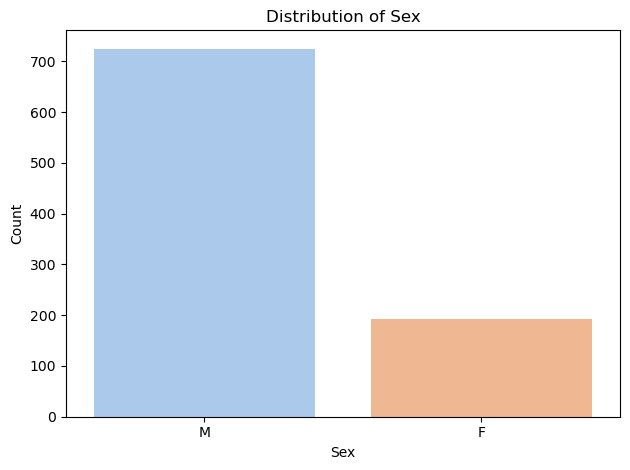

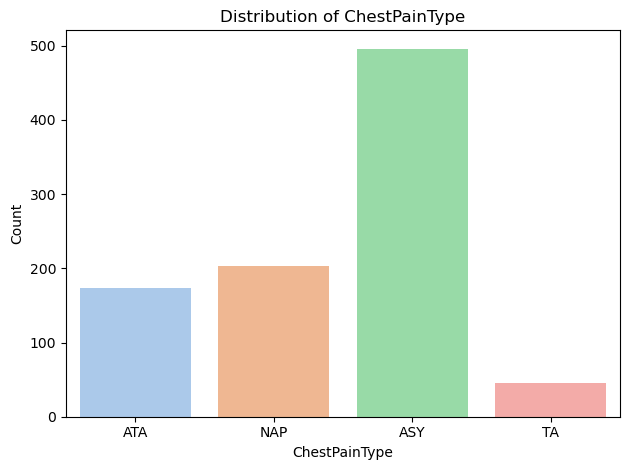

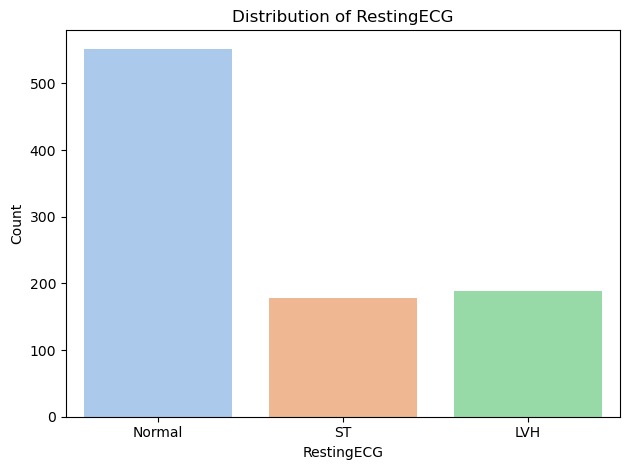

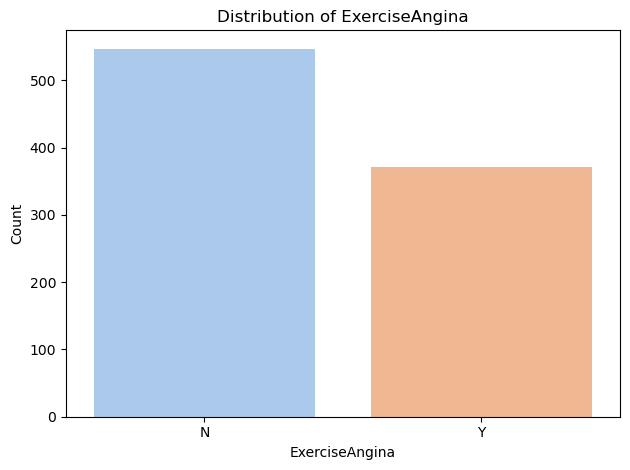

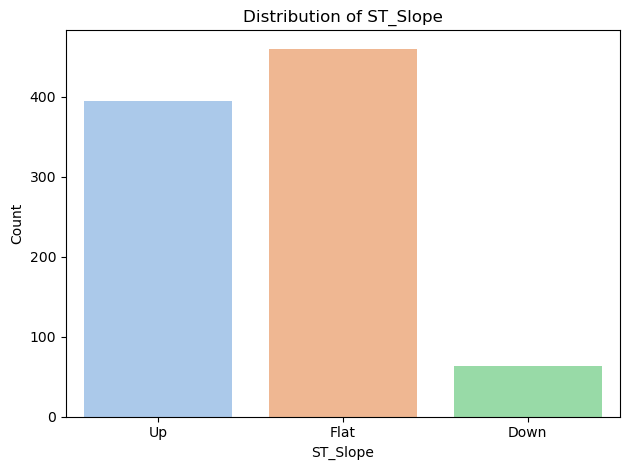

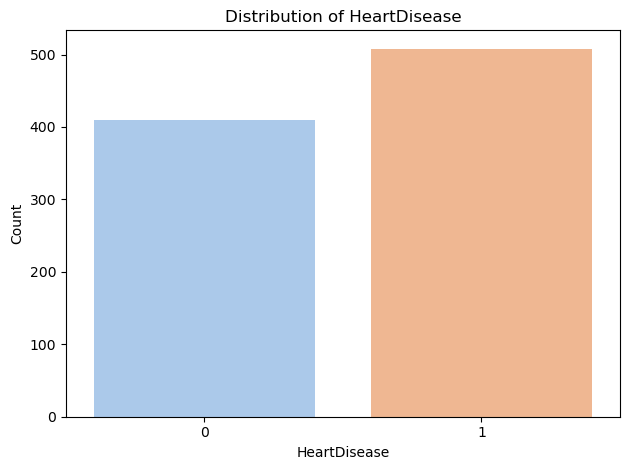

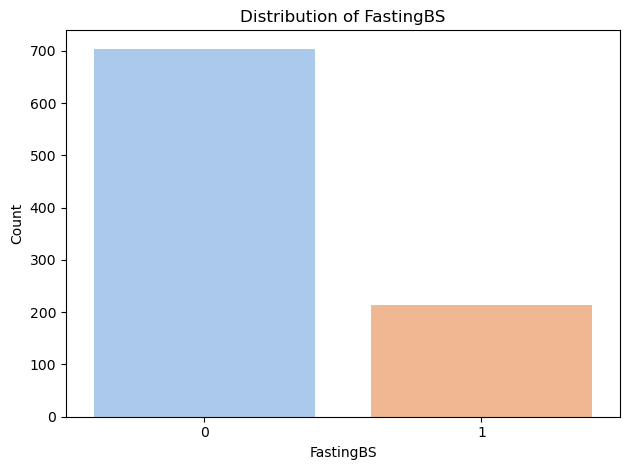

In [10]:
for column in categorical_columns:
    sns.countplot(data=data, x=column, hue=column, palette="pastel", legend=False)
    plt.title(f"Distribution of {column}")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

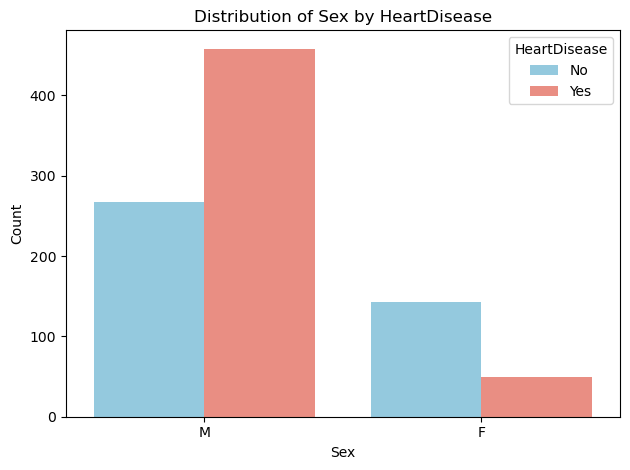

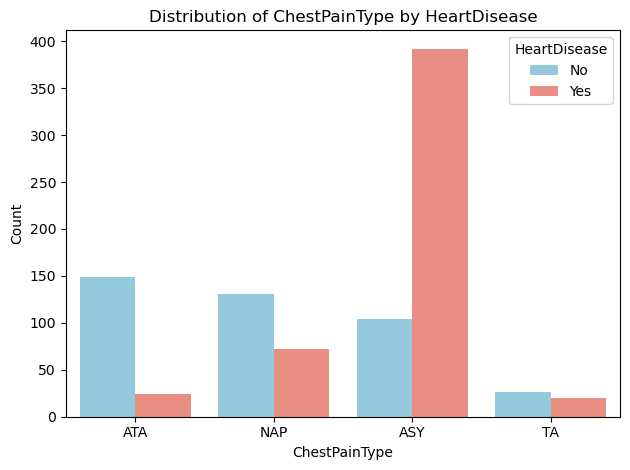

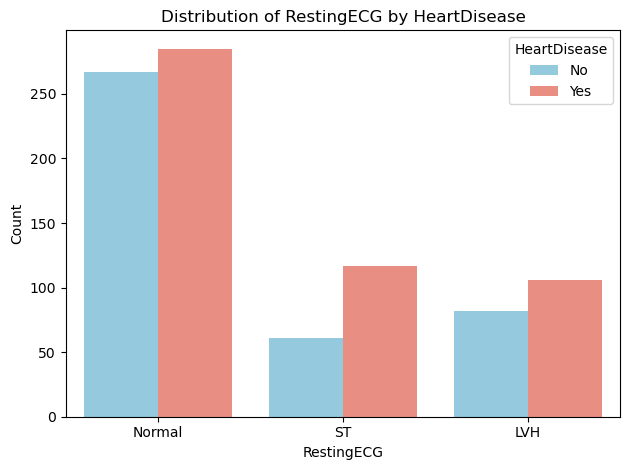

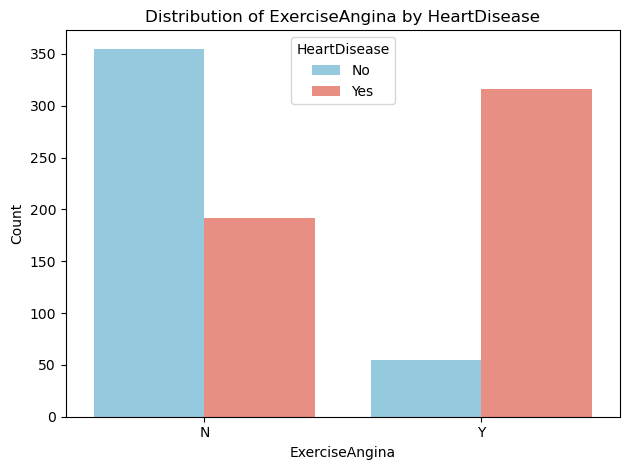

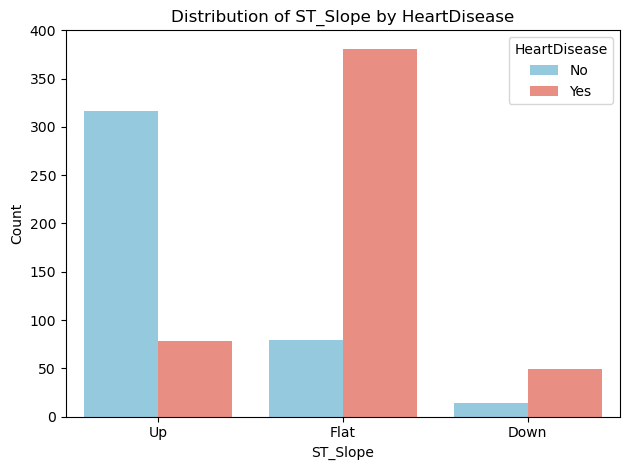

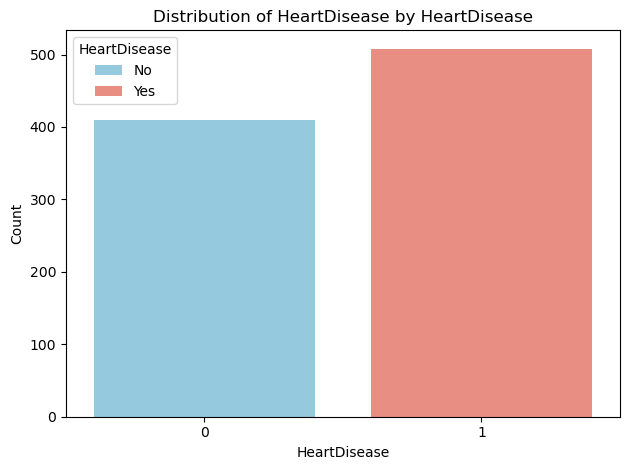

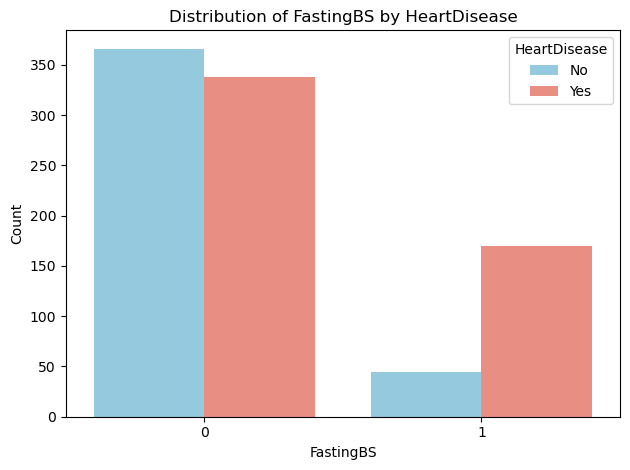

In [11]:
for column in categorical_columns:
    sns.countplot(data=data, x=column, hue="HeartDisease", palette=["skyblue", "salmon"])
    plt.title(f'Distribution of {column} by HeartDisease')
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.legend(title="HeartDisease", labels=["No", "Yes"])
    plt.tight_layout()
    plt.show()

### Summary of Key Insights from Categorical Features

- Males are more likely to have heart disease than females.
- Asymptomatic (ASY) chest pain type is strongly associated with heart disease.
- A flat ST slope and having exercise-induced angina are highly indicative of heart disease.
- Patients with fasting blood sugar levels greater than 120 mg/dl are more likely to have heart disease.
- The dataset contains slightly more heart disease cases (55%) than non-cases (45%).

These categorical variables show strong relationships with the target variable and are likely to be valuable predictors in a classification model.

In [13]:
subset = data[(data["Age"] > 50) & (data["Sex"] == "M")]
percent_male_cvd_over_50 = (subset[subset["HeartDisease"] == 1].shape[0] / subset.shape[0]) * 100

cvd_median_age = data[data["HeartDisease"] == 1]["Age"].median()

print(f"Percentage of males over 50 with heart disease: {percent_male_cvd_over_50:.2f}%")
print(f"Median age of patients with heart disease: {cvd_median_age:.1f} years")

Percentage of males over 50 with heart disease: 70.64%
Median age of patients with heart disease: 57.0 years


### Summary of Data Exploration and Next Steps

We confirmed that the dataset contains no missing values. However, our categorical plots and group-based counts revealed important patterns:

- The dataset is skewed towards male patients, which could introduce bias in model predictions.
- The target variable `HeartDisease` is fairly balanced, which is beneficial for training.
- A large number of patients with heart disease reported asymptomatic chest pain, which could be a valuable yet nuanced feature.
- Elevated blood sugar appears more frequently among patients with heart disease, indicating a potential relationship.

Although there are no missing values, we identified unrealistic zeros in some numerical columns (e.g., `RestingBP`, `Cholesterol`). These will be treated as invalid entries.

Before modeling, we will handle these values either by:
- Removing rows with invalid data (if few),
- Imputing with median values (either globally or grouped by relevant features like `HeartDisease`).

Given the dataset's limited size, we will proceed with a simple median imputation strategy.

In [15]:
restingbp_zeros = data[data["RestingBP"] == 0].shape[0]
cholesterol_zeros = data[data["Cholesterol"] == 0].shape[0]

print(f"Number of patients with RestingBP = 0: {restingbp_zeros}")
print(f"Number of patients with Cholesterol = 0: {cholesterol_zeros}")

Number of patients with RestingBP = 0: 1
Number of patients with Cholesterol = 0: 172


### Handling Invalid Zero Values in Numerical Features

While the dataset has no missing values, we identified some invalid entries that need correction:

- `RestingBP` has 1 patient with a value of `0`, which is not physiologically realistic.
- `Cholesterol` has 172 patients with a value of `0`, which is also not plausible.

To address these:

- For `RestingBP = 0`, we will remove the single row from the dataset, as its impact on model performance will be negligible.
- For `Cholesterol = 0`, we will replace the zero values with the median cholesterol level, calculated within each HeartDisease group (i.e., separate medians for patients with and without heart disease).

This approach preserves as much data as possible while correcting inaccuracies in a medically reasonable way.

In [17]:
data = data.drop(data[data["RestingBP"] == 0].index)

In [18]:
data["Cholesterol"] = data["Cholesterol"].replace(0, np.nan)

imputer = KNNImputer(n_neighbors=5)
data[["Cholesterol"]] = imputer.fit_transform(data[["Cholesterol"]])

In [19]:
restingbp_zeros = data[data["RestingBP"] == 0].shape[0]
cholesterol_zeros = data[data["Cholesterol"] == 0].shape[0]

print(f"Number of patients with RestingBP = 0: {restingbp_zeros}")
print(f"Number of patients with Cholesterol = 0: {cholesterol_zeros}")

Number of patients with RestingBP = 0: 0
Number of patients with Cholesterol = 0: 0


In the dataset, we identified a significant number of invalid zero values in the `Cholesterol` column (172 entries). These zeros are not physiologically meaningful and could negatively affect model performance.

To address this, we used `KNNImputer` from `sklearn.impute`, which estimates missing or invalid values based on the values of neighboring data points. This imputation method is more sophisticated than simply filling with the median or mean, as it:

- Takes into account similarities between observations across multiple features.
- Can preserve complex relationships in the data.
- Provides context-aware imputation, especially useful when multiple features are correlated.

We first replaced invalid zeros with `NaN` to indicate missingness, then applied `KNNImputer` to infer more realistic values using the k-nearest neighbors algorithm.

This approach helps us clean the data while retaining the patterns necessary for accurate modeling.

### Feature Preparation and Selection

To prepare the data for modeling, we first convert categorical variables into dummy (one-hot encoded) variables. This step ensures that all features are in a numerical format suitable for machine learning algorithms.

Once encoding is complete, we examine the correlation heatmap to understand how each feature relates to the target variable (`HeartDisease`). Based on these correlations and our earlier analysis, we select the most relevant features for our model.

In [36]:
categorical_columns = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

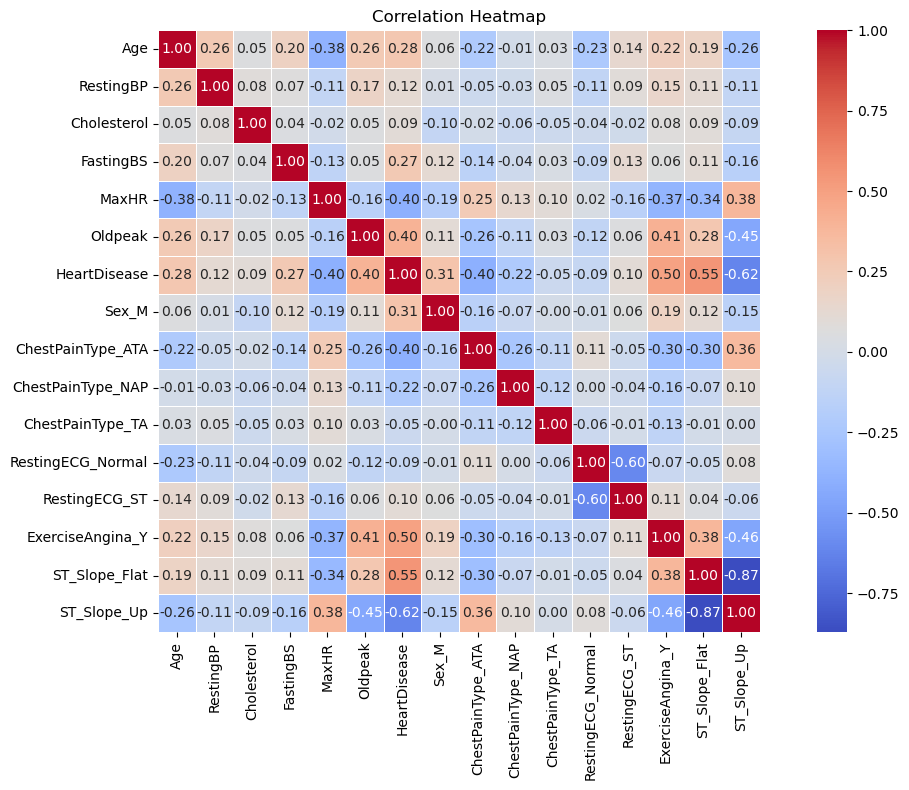

In [38]:
correlations = data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [44]:
correlations = data.corr()
r_squared = correlations["HeartDisease"]**2
top_features = r_squared.sort_values(ascending=False)[1:6].index
print(top_features)

Index(['ST_Slope_Up', 'ST_Slope_Flat', 'ExerciseAngina_Y', 'Oldpeak',
       'ChestPainType_ATA'],
      dtype='object')


### Square of the Pearson Correlation Coefficient (`r²`) for Feature Selection

To evaluate the strength of the relationship between each feature and the target variable (`HeartDisease`), we used the square of the Pearson correlation coefficient (`r²`).

Unlike the raw correlation (`r`), which captures both strength and direction, `r²` focuses solely on predictive strength. It tells us how much of the variance in the target variable can be explained by a given feature, regardless of whether the relationship is positive or negative.

By using `r²`, we can:
- Rank features based on their predictive power.
- Ensure that strong negative relationships are not overlooked.
- Make a more objective selection of features that are statistically meaningful.

This approach helps us prioritize features that contribute the most to predicting heart disease.

### Building a Classifier – Part I: Feature Selection

To select features for our model, we used the square of the Pearson correlation coefficient (\( r^2 \)), which represents the proportion of variance in the target variable (`HeartDisease`) that can be explained by each feature. This method allows us to rank features by their predictive strength, regardless of whether the relationship is positive or negative.

Based on this approach, we selected the following features:

- `ST_Slope_Up`
- `ST_Slope_Flat`
- `ExerciseAngina_Y`
- `Oldpeak`
- `ChestPainType_ATA`

These features showed the highest \( r^2 \) values with respect to `HeartDisease`, indicating they may provide the most predictive value for classification.

Next, we will train models using each of these features individually to assess their performance in predicting heart disease.

In [49]:
y = data["HeartDisease"]
X = data.drop("HeartDisease", axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [85]:
sel_features = ["ST_Slope_Up", "ST_Slope_Flat", "ExerciseAngina_Y", "Oldpeak", "ChestPainType_ATA"]

for feature in sel_features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    y_pred = knn.predict(X_val[[feature]])
    print(f"Accuracy of the model trained on the {feature} is:", accuracy_score(y_val, y_pred))

Accuracy of the model trained on the ST_Slope_Up is: 0.7880434782608695
Accuracy of the model trained on the ST_Slope_Flat is: 0.7608695652173914
Accuracy of the model trained on the ExerciseAngina_Y is: 0.6739130434782609
Accuracy of the model trained on the Oldpeak is: 0.6195652173913043
Accuracy of the model trained on the ChestPainType_ATA is: 0.391304347826087


**Model Performance by Individual Feature**

Among the models trained on individual features, the one trained on `ST_Slope_Up` achieved the highest validation accuracy of 78.8%. This suggests that `ST_Slope_Up` is the most predictive feature for detecting heart disease in this dataset, based on the selected features. Other features such as `ST_Slope_Flat` and `ChestPainType_ATA` also showed reasonable performance, while `ExerciseAngina_Y` and `Oldpeak` were less effective when used alone.

**Underperforming Features**

The features `ExerciseAngina_Y` and `Oldpeak` resulted in the lowest validation accuracy scores, each around 67.4%. 

This underperformance could be due to several reasons:

- When used individually, these features may not carry enough discriminative power to effectively separate the classes (`HeartDisease` = 0 or 1).
- `ExerciseAngina_Y` is a binary feature, which may limit the amount of information it provides to the model on its own.
- `Oldpeak`, although a numeric feature, may interact more strongly with other variables (e.g. `ST_Slope` or `ChestPainType`), and its predictive value is better captured in combination rather than isolation.

These results highlight the importance of feature interactions and suggest that combining multiple features may lead to better performance.

### Building a Classifier II – Combining Features

Previously, we trained separate models using individual features, while these results are promising, training a model on all selected features together may provide even better performance by capturing interactions between them.

Before combining features, we need to ensure the data is normalized. Since K-Nearest Neighbors (KNN) is a distance-based algorithm, having features on different scales can bias the results. For example, a numeric feature with a large range could dominate the distance calculation.

To address this, we will apply Min-Max Scaling to our selected features, transforming their values into the range (0, 1). This ensures each feature contributes equally to the distance metric used by the model.

We’ll now proceed to scale and train the model using all selected features.

In [71]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train[sel_features])
X_val_scaled = scaler.transform(X_val[sel_features])

In [87]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_val_scaled)
print("Accuracy of the model is:", accuracy_score(y_val, y_pred))

Accuracy of the model is: 0.7934782608695652


### Model Performance Comparison

Previously, we trained individual models using each selected feature. Among those, the feature `ST_Slope_Up` gave the highest validation accuracy of **78.8%**, while others like `Oldpeak` and `ChestPainType_ATA` performed significantly worse.

After combining all selected features and scaling them, the new model achieved a validation accuracy of **79.3%**, which is slightly better than the best-performing individual feature model.

This improvement indicates that combining relevant features allows the model to learn more complex patterns, leading to better predictive performance compared to using features individually.

### Hyperparameter Tuning with GridSearchCV

Our initial model trained on all selected and scaled features achieved a validation accuracy of **79.3%**. While this is only a modest improvement over using just the `ST_Slope_Flat` feature, it's a solid foundation.

To improve the model further, we can fine-tune its hyperparameters using GridSearchCV. This method systematically tests combinations of parameter values and selects the configuration that yields the best performance based on cross-validation.

For the `KNeighborsClassifier`, we can tune the following:
- `n_neighbors`: Number of neighbors to use.
- `weights`: How to weight neighbors (e.g., `'uniform'` or `'distance'`).
- `metric`: Distance metric to use (e.g., `'minkowski'`, `'manhattan'`, `'euclidean'`).

Since `GridSearchCV` performs its own internal cross-validation, we no longer need a separate validation set. Instead, we can split the data into training and test sets and let GridSearchCV handle the tuning.

We'll now update our workflow to use GridSearchCV for model selection.

In [92]:
y = data["HeartDisease"]
X = data.drop("HeartDisease", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [98]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[sel_features])

param_grid = {
    'n_neighbors': list(range(1, 21)),               
    'weights': ['uniform', 'distance'],              
    'metric': ['minkowski', 'manhattan', 'euclidean'] 
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,                  
    n_jobs=-1             
)

grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['minkowski', 'manhattan', 'euclidean'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [100]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.2f}")

Best parameters: {'metric': 'minkowski', 'n_neighbors': 6, 'weights': 'uniform'}
Best cross-validation accuracy: 0.85


In [102]:
y_pred = grid_search.best_estimator_.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy with best model: {val_accuracy:.2f}")

Validation accuracy with best model: 0.78


### Model Accuracy and Hyperparameter Tuning Results

After performing hyperparameter tuning using `GridSearchCV`, the best cross-validation accuracy achieved was **85%**. The optimal combination of hyperparameters included:

- `n_neighbors`: **6**  
- `weights`: **uniform**  
- `metric`: **minkowski**

When this optimized model was evaluated on the validation set, it achieved an **accuracy of 78%**.

Compared to our previous models:
- The model using only `ST_Slope_Flat` achieved ~76% accuracy.
- The model trained on all selected features without tuning achieved ~79% accuracy.

The tuned model provides slightly improved generalization. The observed difference between cross-validation and validation accuracy is expected, as the validation set represents truly unseen data. Overall, hyperparameter tuning helped refine model performance and reinforced the importance of model selection and evaluation.

In [108]:
X_test_scaled = scaler.transform(X_test[sel_features])

y_pred = grid_search.best_estimator_.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy with best model: {test_accuracy:.2f}")

Test set accuracy with best model: 0.78


### Final Model Evaluation on Test Set

The final model was evaluated using the held-out test set. After scaling the selected features and using the best estimator from GridSearchCV, the model achieved a test accuracy of **0.78**.

This accuracy is consistent with the validation results and suggests the model generalizes well to unseen data.

**Observations:**
- If the test accuracy is **higher** than the training/validation accuracy, it may be due to the test set having slightly easier or more balanced samples.
- The model’s performance is strong, but further improvements could include:
  - Trying more features
  - Testing other classifiers (e.g., Logistic Regression, Random Forest)
  - Addressing class imbalance if it exists

**Real-world implications in healthcare:**

**Pros:**
- Simple and interpretable
- No assumptions about data distribution
- Flexible with feature types

**Cons:**
- Computationally expensive on large datasets
- Sensitive to feature scaling and irrelevant features
- No probabilistic outputs unless explicitly handled